In [1]:
import pdb
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import os
from loltest import *
from image_utils import *
from utils import *
from efficientnet_pytorch.model import *
import shap
%matplotlib inline

In [2]:
def get_cam_on_image(img, mask):
    '''`img` is RGB numpy input, mask is grad cam output'''
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = cv2.addWeighted(np.float32(img), 0.6, heatmap, 0.4, 0)
    cam = cam / np.max(cam)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    return cam 

In [50]:
class GradCam:
    def __init__(self, model, use_cuda, size):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        self.size = size
        if self.cuda:
            self.model = model.cuda()
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad
        
    def extractor(self, x):
        self.gradients = None
        features = self.model.extract_features(x)
        features.register_hook(self.save_gradient)
        output = F.adaptive_avg_pool2d(features, 1).squeeze(-1).squeeze(-1)
        output = self.model._fc(output)
        return features, output

    def forward(self, input):
        return self.model(input) 

    def __call__(self, input, index = None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        for params in model.modules():
            params.zero_grad()
        org_out = torch.sigmoid(output.detach().clone())
        output = output.mean()
        output.backward(retain_graph=True)
        # now the gradients get filled thanks to the hooks

        grads_val = self.gradients.cpu().data.numpy()
        ## 1x2048x7x7

        target = features.cpu().data.numpy()[0, :]
        # 2048x7x7
        
        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        # 2048
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (self.size, self.size))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam, org_out.cpu().numpy()


In [51]:
home = '/media/ags/DATA/CODE/kaggle/aptos2019-blindness-detection/'
ckpt_path = os.path.join(home, "weights/318_effnet-b5_f1_pord/ckpt17.pth")
# ckpt_path = os.path.join(home, "weights/218_efficientnet-b5_f1_po6cc/ckpt16.pth")
size = 256
num_classes = 5
model_name = "efficientnet-b5"
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [52]:
model = get_model(model_name, num_classes, pretrained=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"]);

grad_cam = GradCam(model = model, use_cuda=True, size=size)

In [53]:
class TestDataset(data.Dataset):
    def __init__(self, root, df, size, mean, std, predict_on, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["id_code"])
        self.num_samples = len(self.fnames)
        self.labels = df['diagnosis'].tolist()
        self.tta = tta
        self.ext = ".png" if predict_on ==  "test" else ""
        self.TTA = albumentations.Compose(
            [
                albumentations.Transpose(p=0.5),
                albumentations.Flip(p=0.5),
                albumentations.ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=120,
                    p=0.5,
#                     border_mode=cv2.BORDER_CONSTANT,
                ),
                albumentations.RandomBrightnessContrast(p=0.25),
            ]
        )
        self.transform = albumentations.Compose(
            [
                albumentations.Resize(size, size),
                albumentations.Normalize(mean=mean, std=std, p=1),
                AT.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        label = self.labels[idx]
        path = os.path.join(self.root, fname.split('.')[0] + '.npy')
        image = np.load(path)
#         image = np.array(Image.open(path))
#         image = aug_11(path)
#         image = id_to_image(path,
#                 resize=True,
#                 size=self.size,
#                 augmentation=False,
#                 subtract_median=True,
#                 clahe_green=False) 
#         w, h, _ = image.shape
#         image = self.TTA(image=image)["image"]
        images = [self.transform(image=image)["image"]]
        for _ in range(self.tta):  # perform ttas
            aug_img = self.TTA(image=image)["image"]
            aug_img = self.transform(image=aug_img)["image"]
            images.append(aug_img)
        return [fname, label], torch.stack(images, dim=0)

    def __len__(self):
        return self.num_samples



In [54]:
def unnormalize(img):
    img = img.clone() # V. Imp
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    #return (img * std) + mean
    for t, m, s in zip(img, mean, std):    
        t.mul_(s).add_(m)
    return img

In [55]:

predict_on = 'train'
if predict_on == "test":
    sample_submission_path = os.path.join(home, "data/sample_submission.csv")
elif predict_on == "train":
    sample_submission_path =  os.path.join(home, "data/train.csv")
elif predict_on == "train_mess":
    sample_submission_path = os.path.join(home, "data/train_messidor.csv")
# sample_submission_path = os.path.join(home, "weights/118_efficientnet-b5_f1_postraug2/diff.csv")
tta = 0  # number of augs in tta
# root = os.path.join(home, "data/test_images/")
root = os.path.join(home, 'data/npy_files/aug_11/')
#if predict_on == "train":
#    root = os.path.join(home, "data/all_images/")
#elif predict_on == "train_mess":
#    root = os.path.join(home, "external_data/messidor/train_images/")
#root = 'data/npy_files/bgcc456'
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
base_th = [0.5, 1.5, 2.5, 3.5]
num_workers = 1
batch_size = 1

df = pd.read_csv(sample_submission_path)
# df = pd.read_csv('../data/diff/diff.csv', index_col=0) # the examples where this model `poma` ensemble failed 
# df['id_code'] += '.png' ####################################

testset = DataLoader(
    TestDataset(root, df, size, mean, std, predict_on, tta),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if use_cuda else False,
)

dataloader = iter(testset)
df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


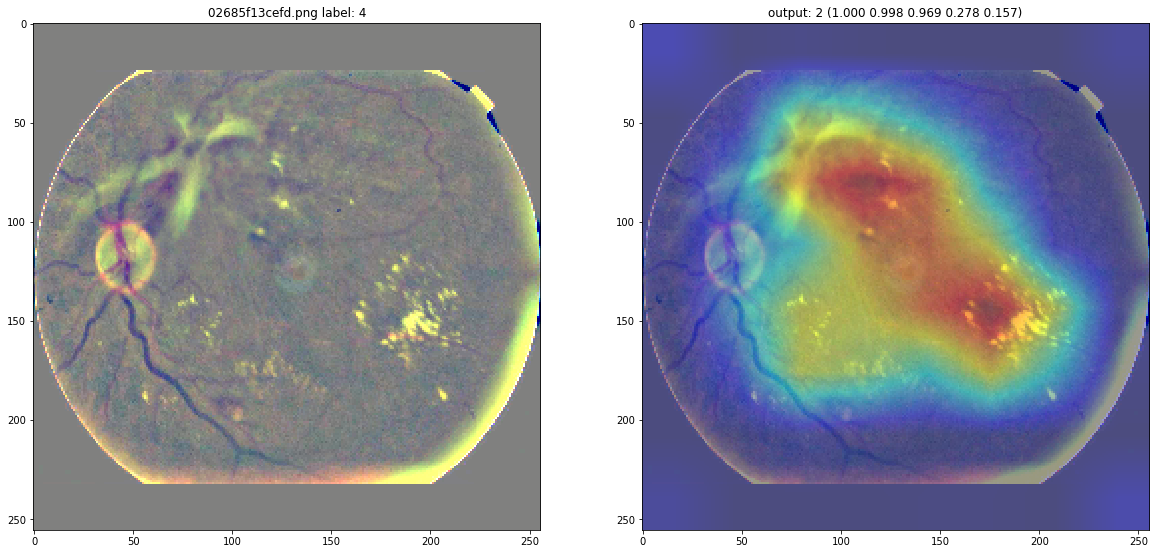

02685f13cefd.png


In [126]:
batch = next(dataloader)
[fnames, labels], images = batch
images = images[:, 0, ...]
images = images.to(device)
images.requires_grad = True
mask, output = grad_cam(images)
image = unnormalize(images[0].detach()).permute(1, 2, 0).numpy()
cam = get_cam_on_image(image, mask)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
# org_img = Image.open(f'../data/test_images/{fnames[0]}.png')
# org_img = Image.open(f'../data/aug_3/{fnames[0]}')
# plt.imshow(org_img.resize((size, size)))
plt.imshow(image)
plt.title('%s label: %d' % (fnames[0], labels[0]))
plt.subplot(1, 2, 2)
plt.imshow(cam)
# plt.title('output: %d (%0.4f)' % (predict(output, base_th)[0], output[0, 0]))
plt.title('output: %d (%s)' % (get_preds((output>0.5).astype('uint8'), 5)[0], ' '.join(map(str, ['%0.3f' % x for x in output.flatten().tolist()]))))
plt.show()
print(fnames[0])

In [ ]:
# model is missing hemorrhages specially large ones and abnormal growth of blood vessels, it is good with hard exudates and cotton wool spots, 

In [128]:
output > [0.5, 0.5, 0.5, 0.2, 0.1]

array([[ True,  True,  True,  True,  True]])

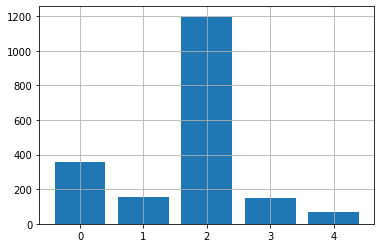

In [124]:
plt.bar(labels, data)
plt.grid()
plt.show()

In [ ]:
'''wrong label
2221cf5c7935.png, 0, 2
2d07162a13b1.png, 0, 1
4f0866b90c27.png, 3, 4
772af553b8b7.png, 3, 4
bf8092e4001d.png, 3, 4
fcc6aa6755e6.png, 3, 4
4f0866b90c27.png, 3, 4
5b3e7197ac1c.png, 3, 4
'''

''' bad quality
06b71823f9cd.png
0ada12c0e78f.png
0c2e2369dfff.png
'''



# image_path = '../data/all_images/e037643244b7.png'

In [ ]:
def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = Variable(preprocessed_img, requires_grad = True)
    return input


In [ ]:

class GuidedBackpropReLU(Function):

    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input), torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output, positive_mask_1), positive_mask_2)

        return grad_input

class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        # replace ReLU with GuidedBackpropReLU
        for idx, module in self.model.features._modules.items():
            if module.__class__.__name__ == 'ReLU':
                self.model.features._modules[idx] = GuidedBackpropReLU()

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index = None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0,:,:,:]

        return output


In [ ]:
gb_model = GuidedBackpropReLUModel(model = models.vgg19(pretrained=True), use_cuda=True)
gb = gb_model(input, index=target_index)
utils.save_image(torch.from_numpy(gb), 'gb.jpg')

cam_mask = np.zeros(gb.shape)
for i in range(0, gb.shape[0]):
    cam_mask[i, :, :] = mask

cam_gb = np.multiply(cam_mask, gb)
utils.save_image(torch.from_numpy(cam_gb), 'cam_gb.jpg')